# Importing Packages

In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

2024-09-29 19:58:06.945740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 19:58:07.058501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 19:58:07.135920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 19:58:06.951342: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Loading

In [2]:
!rm -rf /home/omar/.keras/datasets/flower_photos

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, fname="flower_photos.tgz", extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), "flower_photos")

The dataset we downloaded contains images of 5 types of flowers:

1. Rose
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips

So, let's create the labels for these 5 classes:

In [4]:
classes = ["roses", "daisy", "dandelion", "sunflowers", "tulips"]

Also, the dataset we have downloaded has following directory structure. n
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

As you can see there are no folders containing training and validation data. Therefore, we will have to create our own training and validation set. Let's write some code that will do this.


The code below creates a `train` and a `val` folder each containing 5 folders (one for each type of flower). It then moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set. In the end our directory will have the following structure:


<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Since we don't delete the original folders, they will still be in our `flower_photos` directory, but they will be empty. The code below also prints the total number of flower images we have for each type of flower.

In [5]:
for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + "/*.jpg")
    print("{}: {} Images".format(cl, len(images)))
    num_train = int(round(len(images) * 0.8))
    train, val = images[:num_train], images[num_train:]

    for t in train:
        if not os.path.exists(os.path.join(base_dir, "train", cl)):
            os.makedirs(os.path.join(base_dir, "train", cl))
        shutil.move(t, os.path.join(base_dir, "train", cl))

    for v in val:
        if not os.path.exists(os.path.join(base_dir, "val", cl)):
            os.makedirs(os.path.join(base_dir, "val", cl))
        shutil.move(v, os.path.join(base_dir, "val", cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [6]:
round(len(images) * 0.8)

639

For convenience, let us set up the path for the training and validation sets

In [7]:
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# Data Augmentation

Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In **tf.keras** we can implement this using the same **tf.keras.preprocessing.image.tf.keras.preprocessing.image.ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

## Experiment with Various Image Transformations

###  Set Batch and Image Size

In [8]:
batch_size = 100
IMG_SHAPE = 150
EPOCHS = 80

### Apply Random Horizontal Flip

In the cell below, use tf.keras.preprocessing.image.tf.keras.preprocessing.image.ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random horizontal flip. Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, and to shuffle the images.

In [9]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True
)

train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
)

Found 2935 images belonging to 5 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

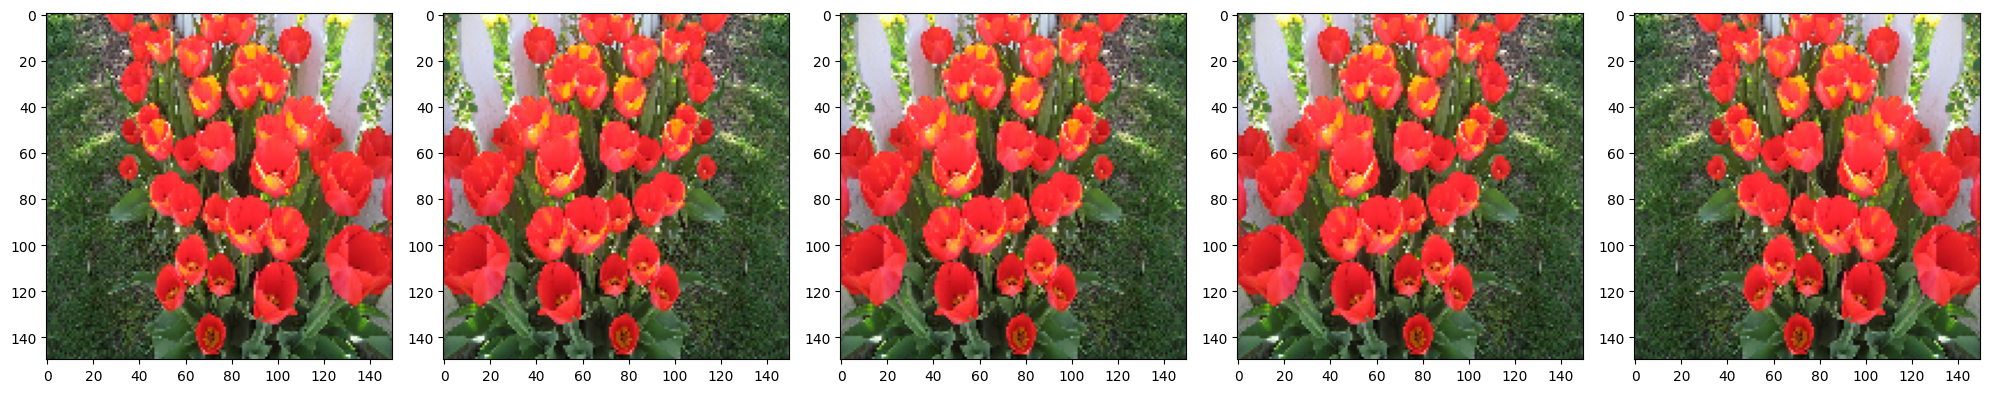

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Apply Random Rotation

In the cell below, use tf.keras.preprocessing.image.tf.keras.preprocessing.image.ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random 45 degree rotation. Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, and to shuffle the images.

In [11]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, rotation_range=45
)

train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
)

Found 2935 images belonging to 5 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

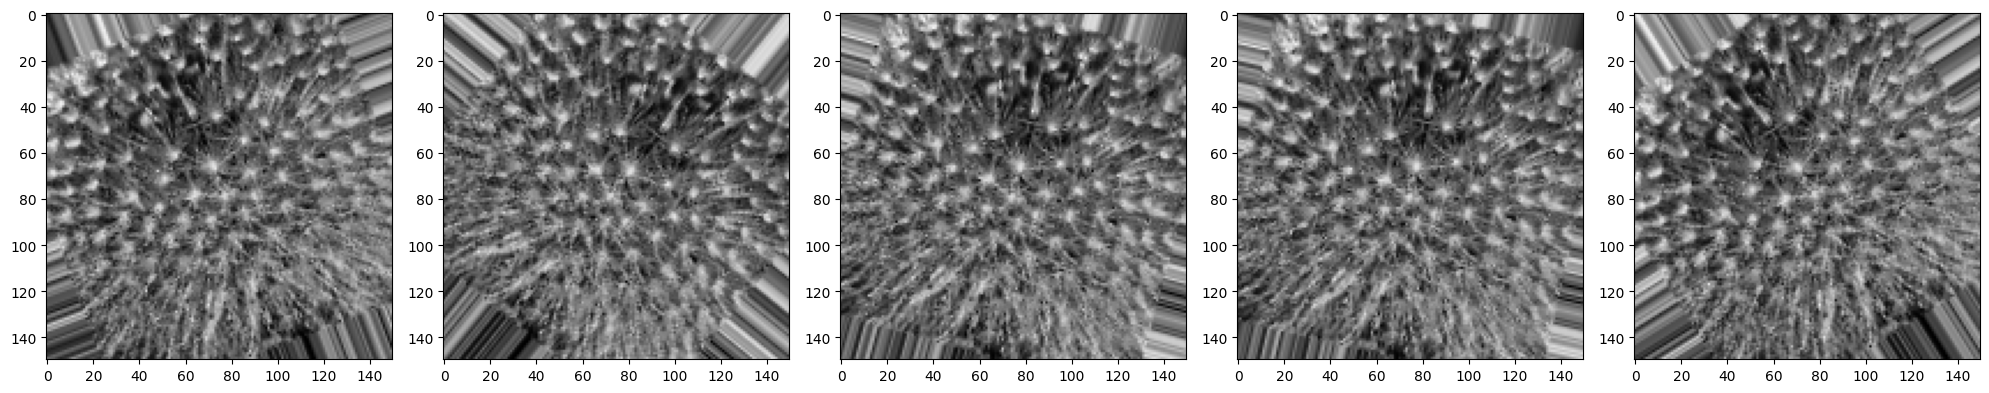

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Apply Random Zoom

In the cell below, use tf.keras.preprocessing.image.tf.keras.preprocessing.image.ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random zoom of up to 50%. Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, and to shuffle the images.

In [13]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, zoom_range=0.5
)

train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
)

Found 2935 images belonging to 5 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

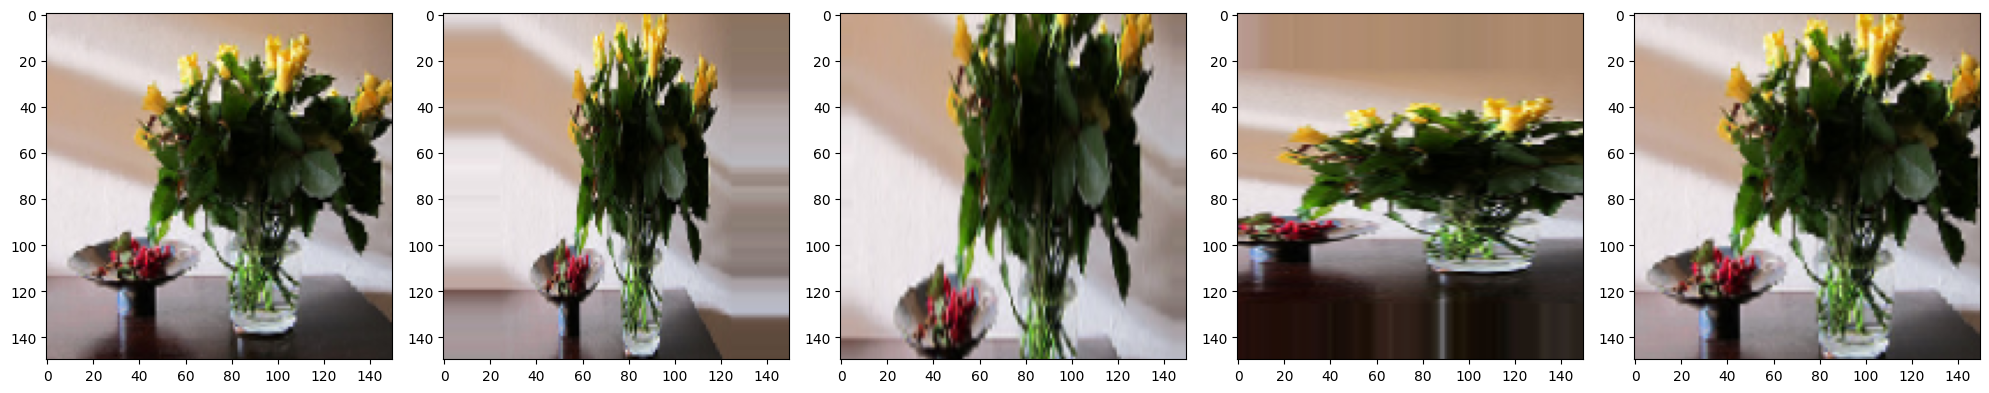

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Put It All Together

In the cell below, use tf.keras.preprocessing.image.tf.keras.preprocessing.image.ImageDataGenerator to create a transformation that rescales the images by 255 and that applies:

- random 45 degree rotation
- random zoom of up to 50%
- random horizontal flip
- width shift of 0.15
- height shift of 0.15

Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, to shuffle the images, and to set the class mode to `sparse`.

In [15]:
image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.5,
)


train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode="sparse",
)

Found 2935 images belonging to 5 classes.


Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset.

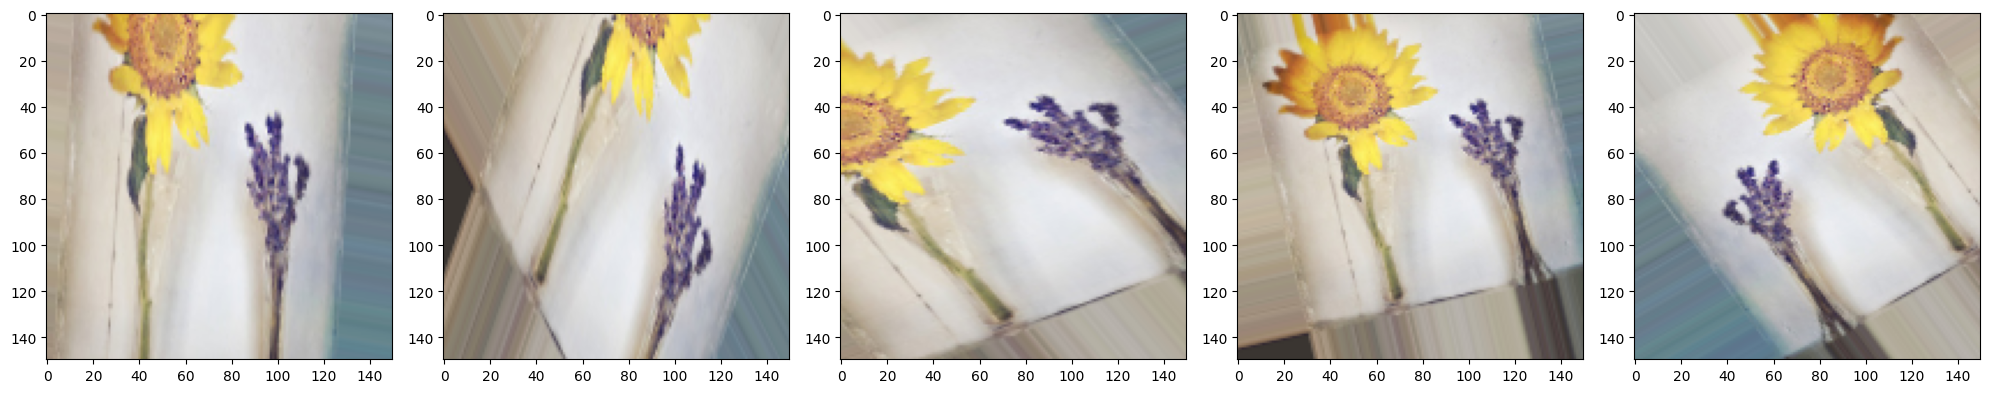

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create a Data Generator for the Validation Set

In [17]:
image_gen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode="sparse",
)

Found 735 images belonging to 5 classes.


# Create the CNN

In [18]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Conv2D(
        16, 3, padding="same", activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 3)
    )
)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation="relu"))

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation="softmax"))  # Use softmax for multi-class

/home/omar/miniconda3/envs/.tf217/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727629146.041407    9579 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727629146.249660    9579 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727629146.249744    9579 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727629146.255662    9579 

# Compile the Model

In [19]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False
    ),  # from_logits should be False for softmax
    metrics=["accuracy"],
)

# Train the Model

In [20]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
)

Epoch 1/80


/home/omar/miniconda3/envs/.tf217/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727629161.465155    9862 service.cc:146] XLA service 0x7f8f90003990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727629161.465393    9862 service.cc:154]   StreamExecutor device (0): Quadro T2000, Compute Capability 7.5
2024-09-29 19:59:21.633841: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-29 19:59:22.210938: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-29 19:

17/30 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1849 - loss: 1.8675   

2024-09-29 20:00:07.328878: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k5=1,k6=0,k7=1,k10=1} for conv (f32[35,16,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[35,32,75,75]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-09-29 20:00:07.338411: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 9.874480845s
Trying algorithm eng19{k5=1,k6=0,k7=1,k10=1} for conv (f32[35,16,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[35,32,75,75]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2028 - loss: 1.7866

2024-09-29 20:00:22.343058: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[100,32,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,16,75,75]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-09-29 20:00:22.389182: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 10.061764959s
Trying algorithm eng12{k11=2} for conv (f32[100,32,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,16,75,75]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", ba

30/30 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.2047 - loss: 1.7817 - val_accuracy: 0.4259 - val_loss: 1.3412
Epoch 2/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/80


2024-09-29 20:00:17.177337: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-29 20:00:17.177526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:00:17.177561: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/omar/miniconda3/envs/.tf217/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-09-29 20:00:17.197379: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with

30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 633ms/step - accuracy: 0.4719 - loss: 1.2842 - val_accuracy: 0.5306 - val_loss: 1.1058
Epoch 4/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/80


2024-09-29 20:00:41.795336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:00:41.795428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:00:41.802577: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-29 20:00:41.802655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:00:41.802702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 780ms/step - accuracy: 0.5415 - loss: 1.1338 - val_accuracy: 0.5497 - val_loss: 1.0936
Epoch 6/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/80


2024-09-29 20:01:10.718816: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:01:10.718960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:01:10.727454: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:01:10.727561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 679ms/step - accuracy: 0.5584 - loss: 1.1118 - val_accuracy: 0.5823 - val_loss: 1.0335
Epoch 8/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/80


2024-09-29 20:01:37.494385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:01:37.494609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:01:37.516338: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-29 20:01:37.516579: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:01:37.516742: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 728ms/step - accuracy: 0.5854 - loss: 1.0267 - val_accuracy: 0.6041 - val_loss: 0.9350
Epoch 10/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/80


2024-09-29 20:02:05.991536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:02:05.991707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:02:06.004203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:02:06.004385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 616ms/step - accuracy: 0.6088 - loss: 0.9725 - val_accuracy: 0.6136 - val_loss: 0.9402
Epoch 12/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/80


2024-09-29 20:02:32.402596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:02:32.402723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:02:32.410103: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:02:32.410221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:02:47.589261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-29 20:02:37.867700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - accuracy: 0.6328 - loss: 0.9356 - val_accuracy: 0.6803 - val_loss: 0.8358
Epoch 14/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 15/80


2024-09-29 20:02:51.800322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:02:51.800386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:02:51.804546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:02:51.804598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.6542 - loss: 0.8850 - val_accuracy: 0.6680 - val_loss: 0.8401
Epoch 16/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 17/80


2024-09-29 20:03:05.558204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:03:05.558266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:03:05.562346: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-29 20:03:05.562390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:03:05.562423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 361ms/step - accuracy: 0.6685 - loss: 0.8357 - val_accuracy: 0.6857 - val_loss: 0.7922
Epoch 18/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 19/80


2024-09-29 20:03:19.136430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:03:19.136495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:03:19.140744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:03:19.140801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.6623 - loss: 0.8485 - val_accuracy: 0.6612 - val_loss: 0.8774
Epoch 20/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 21/80


2024-09-29 20:03:32.807599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:03:32.807664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:03:32.811841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:03:32.811905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.6918 - loss: 0.8082 - val_accuracy: 0.7034 - val_loss: 0.7721
Epoch 22/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 23/80


2024-09-29 20:03:47.013370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:03:47.013470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:03:47.017882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:03:47.017943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.6872 - loss: 0.7943 - val_accuracy: 0.6912 - val_loss: 0.7635
Epoch 24/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 25/80


2024-09-29 20:04:00.671705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:00.671769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:04:00.676097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:00.676151: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.7053 - loss: 0.7475 - val_accuracy: 0.7184 - val_loss: 0.7136
Epoch 26/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 27/80


2024-09-29 20:04:14.700918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:14.700984: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:04:14.705279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:14.705336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.7022 - loss: 0.7492 - val_accuracy: 0.7102 - val_loss: 0.7275
Epoch 28/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 29/80


2024-09-29 20:04:28.520092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:28.520154: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:04:28.524196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:28.524252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.7089 - loss: 0.7594 - val_accuracy: 0.7320 - val_loss: 0.7386
Epoch 30/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 31/80


2024-09-29 20:04:42.598688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:42.598749: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:04:42.603458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:42.603522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.7150 - loss: 0.7315 - val_accuracy: 0.7483 - val_loss: 0.6790
Epoch 32/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 33/80


2024-09-29 20:04:56.411232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:56.411300: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:04:56.415739: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-29 20:04:56.415780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:04:56.415811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:05:07.884072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-09-29 20:04:59.799783: I

30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - accuracy: 0.7177 - loss: 0.7240 - val_accuracy: 0.7279 - val_loss: 0.6942
Epoch 34/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 35/80


2024-09-29 20:05:10.770118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:05:10.770189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:05:10.775078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:05:10.775145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.7316 - loss: 0.7025 - val_accuracy: 0.7374 - val_loss: 0.6816
Epoch 36/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 37/80


2024-09-29 20:05:24.738991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:05:24.739054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:05:24.743406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:05:24.743470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 363ms/step - accuracy: 0.7366 - loss: 0.6908 - val_accuracy: 0.7252 - val_loss: 0.7022
Epoch 38/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 39/80


2024-09-29 20:05:38.814741: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:05:38.814809: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:05:38.819999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:05:38.820069: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 336ms/step - accuracy: 0.7307 - loss: 0.6982 - val_accuracy: 0.7197 - val_loss: 0.7008
Epoch 40/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 41/80


2024-09-29 20:05:52.588040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:05:52.588103: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:05:52.592321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:05:52.592381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step - accuracy: 0.7317 - loss: 0.7000 - val_accuracy: 0.7415 - val_loss: 0.6765
Epoch 42/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 43/80


2024-09-29 20:06:06.929716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:06:06.929780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:06:06.934102: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:06:06.934163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.7373 - loss: 0.6871 - val_accuracy: 0.7361 - val_loss: 0.6825
Epoch 44/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 45/80


2024-09-29 20:06:20.661966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:06:20.662029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:06:20.665994: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:06:20.666048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 363ms/step - accuracy: 0.7704 - loss: 0.6085 - val_accuracy: 0.7293 - val_loss: 0.6878
Epoch 46/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 47/80


2024-09-29 20:06:34.348550: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:06:34.348615: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:06:34.353034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:06:34.353097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.7611 - loss: 0.6329 - val_accuracy: 0.7415 - val_loss: 0.6927
Epoch 48/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 49/80


2024-09-29 20:06:48.191626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:06:48.191688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:06:48.195611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:06:48.195667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.7647 - loss: 0.6351 - val_accuracy: 0.7374 - val_loss: 0.6649
Epoch 50/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 51/80


2024-09-29 20:07:02.461422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:02.461485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:07:02.465733: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:02.465791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 358ms/step - accuracy: 0.7604 - loss: 0.6241 - val_accuracy: 0.7442 - val_loss: 0.6570
Epoch 52/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 53/80


2024-09-29 20:07:16.366420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:16.366512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:07:16.370934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:16.370995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.7636 - loss: 0.6014 - val_accuracy: 0.7374 - val_loss: 0.6740
Epoch 54/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 55/80


2024-09-29 20:07:30.297780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:30.297844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:07:30.302370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:30.302439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step - accuracy: 0.7604 - loss: 0.6309 - val_accuracy: 0.7388 - val_loss: 0.6367
Epoch 56/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 57/80


2024-09-29 20:07:43.972341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:43.972406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:07:43.976651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:43.976708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 362ms/step - accuracy: 0.7645 - loss: 0.6075 - val_accuracy: 0.7469 - val_loss: 0.6763
Epoch 58/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 59/80


2024-09-29 20:07:58.097850: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:58.097916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:07:58.103364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:07:58.103427: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.7648 - loss: 0.6203 - val_accuracy: 0.7497 - val_loss: 0.6670
Epoch 60/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 61/80


2024-09-29 20:08:12.601514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:08:12.601580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:08:12.605635: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:08:12.605690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.7680 - loss: 0.6102 - val_accuracy: 0.7592 - val_loss: 0.6456
Epoch 62/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 63/80


2024-09-29 20:08:26.367090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:08:26.367162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:08:26.371718: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:08:26.371782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.7724 - loss: 0.5955 - val_accuracy: 0.7388 - val_loss: 0.6830
Epoch 64/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 65/80


2024-09-29 20:08:40.179697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:08:40.179762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:08:40.184499: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-29 20:08:40.184551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:08:40.184584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.7886 - loss: 0.5502 - val_accuracy: 0.7211 - val_loss: 0.6903
Epoch 66/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 67/80


2024-09-29 20:08:54.110243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:08:54.110306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:08:54.114610: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:08:54.114668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.7810 - loss: 0.5869 - val_accuracy: 0.7320 - val_loss: 0.7243
Epoch 68/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 69/80


2024-09-29 20:09:07.847570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:09:07.847637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:09:07.852685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:09:07.852748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 366ms/step - accuracy: 0.7668 - loss: 0.5887 - val_accuracy: 0.7388 - val_loss: 0.6968
Epoch 70/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 71/80


2024-09-29 20:09:22.191468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:09:22.191538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:09:22.196624: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:09:22.196687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.7773 - loss: 0.5472 - val_accuracy: 0.7510 - val_loss: 0.6622
Epoch 72/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 73/80


2024-09-29 20:09:35.826682: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:09:35.826748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:09:35.831326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:09:35.831388: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.7899 - loss: 0.5611 - val_accuracy: 0.7673 - val_loss: 0.6276
Epoch 74/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 75/80


2024-09-29 20:09:49.791579: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:09:49.791644: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:09:49.796409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:09:49.796468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.7881 - loss: 0.5618 - val_accuracy: 0.7279 - val_loss: 0.7700
Epoch 76/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 77/80


2024-09-29 20:10:03.711798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:10:03.711864: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:10:03.717573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:10:03.717705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.7801 - loss: 0.5784 - val_accuracy: 0.7306 - val_loss: 0.7506
Epoch 78/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 79/80


2024-09-29 20:10:18.046840: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:10:18.046906: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:10:18.051798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:10:18.051867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 370ms/step - accuracy: 0.7956 - loss: 0.5277 - val_accuracy: 0.7510 - val_loss: 0.6503
Epoch 80/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


2024-09-29 20:10:33.001848: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:10:33.001914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477
2024-09-29 20:10:33.007271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2518549072192002935
2024-09-29 20:10:33.007329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10517178989360707477


# Plot Training and Validation Graphs

## Plot training and validation accuracy/loss

In [21]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]